In [1]:
import pickle
import os
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn import decomposition
import networkx as nx
from networkx.readwrite import write_gexf
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from downloader import Downloader

### Download APT Data

In [2]:
d=Downloader()
d.download()

Making the godown.pl script executable, thanks:https://github.com/circulosmeos/gdown.pl


FileNotFoundError: [WinError 2] Impossibile trovare il file specificato

### Loading APT Data

In [2]:
f = open("data/apt_data.pkl", "rb")
data = pickle.load(f)
f.close()

In [3]:
apt = []
file = []
embeddings = []
for k in data.keys():
    emb = [f['embedding'] for f in data[k]['functions'] if f['lenght'] > 20]
    emb = np.asarray(emb)
    if emb.shape[0] > 0 and data[k]['apt'] != 'Lazarus Group':
        embeddings.append(emb)
        apt.append(data[k]['apt'].replace("\n",""))
        file.append(k)
assert len(apt) == len(embeddings)

### Preparing folds for cross validation

In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
fold = []
for train_index, test_index in skf.split(embeddings, apt):
    fold.append(test_index)

In [5]:
def project(sample, space, SIM_THRESHOLD=0.95):
    projection = []
    for j in range(0, len(space)):
        dot = np.dot(sample, space[j].T)
        dist = np.sum(np.sum(dot > SIM_THRESHOLD, axis=1) > 0) / max(sample.shape[0], space[j].shape[0])
        projection.append(dist)
    return projection

### Do Cross Validation

In [ ]:
C = [100]
gamma = [0.1]

result = []
for i in range(0, 5):
    print("Val fold: {}".format(i))
    val_emb = [embeddings[f] for f in fold[i]]
    val_apt = [apt[f] for f in fold[i]]
    for j in range(0, 5):
        if i == j:
            continue
        projection_emb = [embeddings[f] for f in fold[j]]
        train_fold = set(range(0,5)).difference(set([i,j]))
        train_emb = []
        train_apt = []
        for ff in train_fold:
            train_emb.extend([embeddings[f] for f in fold[ff]])
            train_apt.extend([apt[f] for f in fold[ff]])
        print("Projection fold: {} Train fold: {}".format(j, train_fold))
        print("Projecting training data")
        train_data = []
        for k in tqdm(range(0, len(train_emb))):
            train_data.append(project(train_emb[k], projection_emb))
            
        print("Projecting validation data")
        val_data = []
        for k in tqdm(range(0, len(val_emb))):
            val_data.append(project(val_emb[k], projection_emb))

        max_acc = 0
        best_c = None
        best_gamma = None

        print("Classification")
        for c in tqdm(C):
            for g in gamma:
                clf = SVC(C=c, gamma=g, kernel="rbf")
                clf.fit(train_data, train_apt)
                predictions = clf.predict(val_data)
                acc = metrics.accuracy_score(val_apt, predictions)
                if acc > max_acc:
                    best_c = c
                    best_gamma = g
                    best_predictions = predictions
                    max_acc = acc
                    
        print("Best C: {}, Best GAMMA: {}, Validation Accuracy {}".format(best_c, best_gamma, max_acc))
        
        obj = {
            "val_fold":i,
            "projection_fold":j,
            "train_fold":train_fold,
            "C":best_c,
            "gamma": best_gamma,
            "accuracy": max_acc,
            "predictions":best_predictions,
            "label":val_apt
        }
        
        result.append(obj)


Val fold: 0
Projection fold: 1 Train fold: {2, 3, 4}
Projecting training data



 23%|████████████████████████████                                                                                               | 224/984 [00:16<00:36, 20.77it/s]

### Saving result

In [8]:
import pickle
f = open('result_cross_val_svm.pkl','wb')
pickle.dump(result, f)
f.close()

### Print Confusion Matrix

In [9]:
actual_val_fold = i
cum_report = None
cnf = np.zeros([len(set(result[0]['label'])),len(set(result[0]['label']))])
labels = list(set(result[0]['label']))
for r in result:
    report = metrics.classification_report(r['predictions'], r['label'], output_dict=True)
    cnf = (cnf + metrics.confusion_matrix(r['predictions'], r['label'], labels=labels)) / 2
    if cum_report == None:
        cum_report = report
    else:
        for k in report.keys():
            if k != 'accuracy':
                cum_report[k]['precision'] = (cum_report[k]['precision'] + report[k]['precision']) / 2
                cum_report[k]['recall'] = (cum_report[k]['recall'] + report[k]['recall']) / 2
                cum_report[k]['f1-score'] = (cum_report[k]['f1-score'] + report[k]['f1-score']) / 2
                cum_report[k]['support'] = (cum_report[k]['support'] + report[k]['support']) / 2
            else:
                cum_report[k] = (cum_report[k] + report[k]) / 2

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
labels[4] = 'Sandworm'

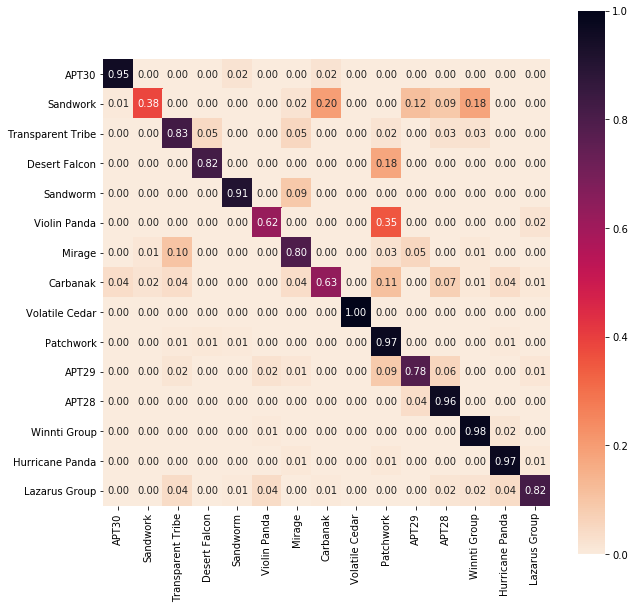

In [12]:
df_cm = pd.DataFrame(cnf, index=labels, columns=labels)
df_cm = df_cm.div(df_cm.sum(axis=1), axis=0)
fig = plt.figure(figsize=(10,10))
heatmap = sns.heatmap(df_cm, annot=True, fmt=".2f", square=True, cmap = sns.cm.rocket_r)
plt.savefig("confusion_matrix_cross_val_svm.png")

In [13]:
report = pd.DataFrame(cum_report).T.round(3)

In [14]:
report

,precision,recall,f1-score,support
APT28,0.612,0.972,0.742,8.875
APT29,0.879,0.786,0.830,32.500
APT30,0.956,0.960,0.956,17.000
Carbanak,0.652,0.683,0.655,14.375
Desert Falcon,0.833,0.828,0.819,8.500
Hurricane Panda,0.968,0.972,0.970,61.750
Lazarus Group,0.897,0.821,0.855,12.625
Mirage,0.727,0.807,0.762,10.000
Patchwork,0.907,0.972,0.938,89.188
Sandwork,0.944,0.386,0.547,22.062


In [15]:
f = open("classification_result_svm_cross_val.tex","w")
f.write(report.to_latex())
f.close()

 32%|███████████████████████████████████████▍                                                                                   | 318/992 [00:30<01:19,  8.49it/s]